In [5]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate, Dropout, Dense, Flatten
from keras.activations import sigmoid
import time
from IPython import display
import os
import pandas as pd
from zipfile import ZipFile
import cv2

In [ ]:
!pip install -U tensorboard

In [ ]:
f = h5py.File('nyu_depth_v2_labeled.mat')
input_train = np.array(f['images'])
label_train = np.array(f['depths'])
edges = np.copy(input_train)
edges_train = []
for i, file in enumerate(edges):
  file = file.transpose(2,1,0)
  file = cv2.Canny(file, 100, 200)
  file = file.transpose(1, 0)
  print(file.shape)
  edges_train.append(file)

edges_train = np.array(edges_train)

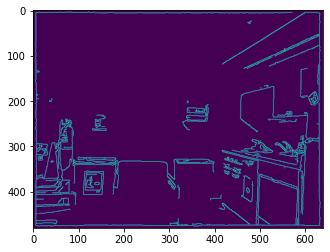

In [ ]:
plt.imshow(edges_train[0].transpose(1,0))

In [19]:
def preprocessing(file):
  input_file = tf.cast(file, tf.float32)
  if len(tf.shape(input_file)) == 2:
    input_file = tf.expand_dims(input_file, axis = 0)
  input_file = tf.transpose(input_file)
  input_file = tf.image.resize(input_file, [256, 256], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  #random mirroring
  # normalizing images to [-1, 1]
  input_file = (input_file / 127.5) - 1
  return input_file


In [20]:
images = tf.data.Dataset.from_tensor_slices((input_train))
labels = tf.data.Dataset.from_tensor_slices((label_train))
edges = tf.data.Dataset.from_tensor_slices((edges_train))
images = images.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
edges = edges.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
labels = labels.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
dataset = tf.data.Dataset.zip((images, edges, labels))
dataset = dataset.shuffle(1000)
train_dataset = dataset.take(1304)
test_dataset = dataset.skip(1304)
train_dataset = train_dataset.batch(1)
test_dataset = test_dataset.batch(1)

In [21]:
OUTPUT_CHANNELS = 1

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
def new_gen():
  input1 = tf.keras.layers.Input(shape=[256, 256, 3])
  input2 = tf.keras.layers.Input(shape=[256, 256, 1])

  b_cnv = input2
  b_cnv1 = downsample(64, 4, apply_batchnorm=False)(b_cnv)
  b_cnv2 = downsample(128, 4)(b_cnv1)
  b_cnv3 = downsample(256, 4)(b_cnv2)
  b_cnv4 = downsample(512, 4)(b_cnv3)
  b_cnv5 = downsample(512, 4)(b_cnv4)
  b_cnv6 = downsample(512, 4)(b_cnv5)
  b_cnv7 = downsample(512, 4)(b_cnv6)
  b_cnv8 = downsample(512, 4)(b_cnv7)

  b_upcnv1 = upsample(512, 4, apply_dropout=True)(b_cnv8)
  b_con1 = Concatenate()([b_upcnv1,b_cnv7])
  b_upcnv2 =  upsample(512, 4, apply_dropout=True)(b_con1)
  b_con2 = Concatenate()([b_upcnv2,b_cnv6])
  b_upcnv3 =  upsample(512, 4, apply_dropout=True)(b_con2)
  b_con3 = Concatenate()([b_upcnv3,b_cnv5])
  b_upcnv4 =  upsample(512, 4)(b_con3)
  b_con4 = Concatenate()([b_upcnv4,b_cnv4])
  b_upcnv5 =  upsample(256, 4)(b_con4)
  b_con5 = Concatenate()([b_upcnv5,b_cnv3])
  b_upcnv6 =  upsample(128, 4)(b_con5)
  b_con6 = Concatenate()([b_upcnv6,b_cnv2])
  b_upcnv7 =  upsample(64, 4)(b_con6)
  b_con7 = Concatenate()([b_upcnv7,b_cnv1])

  a_cnv = input1
  a_cnv1 = downsample(64, 4, apply_batchnorm=False)(a_cnv)
  a_cnv2 = downsample(128, 4)(a_cnv1)
  a_cnv3 = downsample(256, 4)(a_cnv2)
  a_cnv4 = downsample(512, 4)(a_cnv3)
  a_cnv5 = downsample(512, 4)(a_cnv4)
  a_cnv6 = downsample(512, 4)(a_cnv5)
  a_cnv7 = downsample(512, 4)(a_cnv6)
  a_cnv8 = downsample(512, 4)(a_cnv7)

  a_upcnv1 = upsample(512, 4, apply_dropout=True)(a_cnv8)
  a_con1 = Concatenate()([a_upcnv1,a_cnv7,b_con1])
  a_upcnv2 =  upsample(512, 4, apply_dropout=True)(a_con1)
  a_con2 = Concatenate()([a_upcnv2,a_cnv6,b_con2])
  a_upcnv3 =  upsample(512, 4, apply_dropout=True)(a_con2)
  a_con3 = Concatenate()([a_upcnv3,a_cnv5,b_con3])
  a_upcnv4 =  upsample(512, 4)(a_con3)
  a_con4 = Concatenate()([a_upcnv4,a_cnv4,b_con4])
  a_upcnv5 =  upsample(256, 4)(a_con4)
  a_con5 = Concatenate()([a_upcnv5,a_cnv3,b_con5])
  a_upcnv6 =  upsample(128, 4)(a_con5)
  a_con6 = Concatenate()([a_upcnv6,a_cnv2,b_con6])
  a_upcnv7 =  upsample(64, 4)(a_con6)
  a_con7 = Concatenate()([a_upcnv7,a_cnv1,b_con7])

  

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  #x = last(a_con7)
  
  x1 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False)(a_con7)
  x2 = tf.keras.layers.LeakyReLU()(x1)

  x3 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False)(x2)
  x4 = tf.keras.layers.LeakyReLU()(x3)
  x5 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',
                              kernel_initializer=initializer, use_bias=False)(x4)
  x6 = Concatenate()([x5, x2])
  x7 = tf.keras.layers.LeakyReLU()(x6)
  x8 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',
                              kernel_initializer=initializer, use_bias=False)(x7)
  
  x9 = tf.keras.activations.tanh(x8)
  x10 = last(x9)
  
  return tf.keras.Model(inputs = [input1, input2], outputs=x10)
  

In [28]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [38]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.99)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.99)

In [40]:
checkpoint_dir = './training_checkpoints_edge'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
def generate_images(model, test_input, test_edge, tar):
  prediction = model([test_input, test_edge], training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    if display_list[i].shape[-1] ==1:
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(np.squeeze(display_list[i]) * 0.5 + 0.5)
      plt.axis('off')
    else:
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()

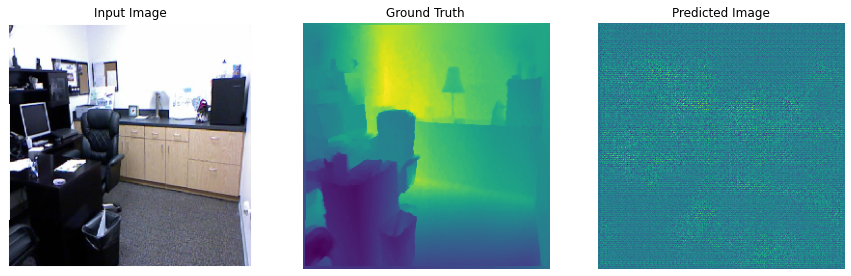

In [42]:
for example_input, example_edge, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_edge, example_target)

In [48]:
EPOCHS = 20

In [49]:
import datetime
log_dir="logs_edge/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [50]:
@tf.function
def train_step(input_image, input_edge, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator([input_image, input_edge], training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  print(f"Epoch:{epoch} | gen_total_loss:{gen_total_loss} | gen_gan_loss:{gen_gan_loss} | gen_l1_loss:{gen_l1_loss} | disc_loss:{disc_loss}")
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [51]:
def fit(train_ds, epochs, test_ds):
  with open('./logs/depth_estimation.log', 'w') as f:
    for epoch in range(epochs):
      start = time.time()
      for example_input, example_edge, example_target in test_ds.take(1):
        generate_images(generator, example_input, example_edge, example_target)
      print("Epoch: ", epoch)
      for n, (input_image, input_edge, target) in train_ds.enumerate():
        a, b, c, d = train_step(input_image, input_edge, target, epoch)

      if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)
    f.write(f"Epoch:{epoch} | gen_total_loss:{a} | gen_gan_loss:{b} | gen_l1_loss:{c} | disc_loss:{d}")

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Now run the training loop:

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [56]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint    ckpt-3.data-00000-of-00001  ckpt-4.index
ckpt-1.index  ckpt-3.index
ckpt-2.index  ckpt-4.data-00000-of-00001


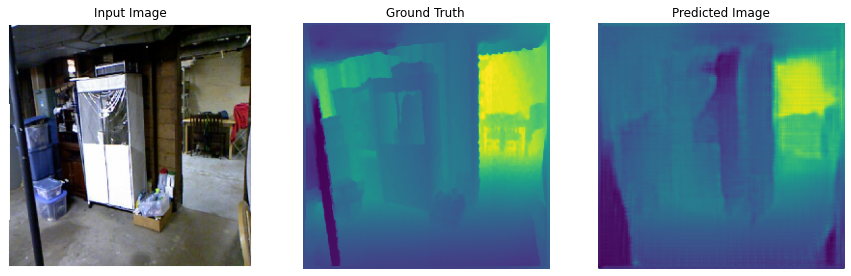

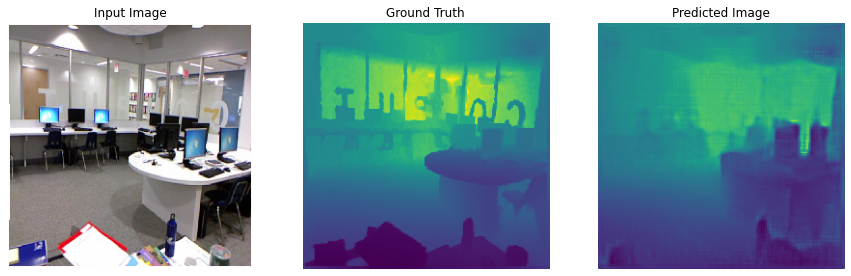

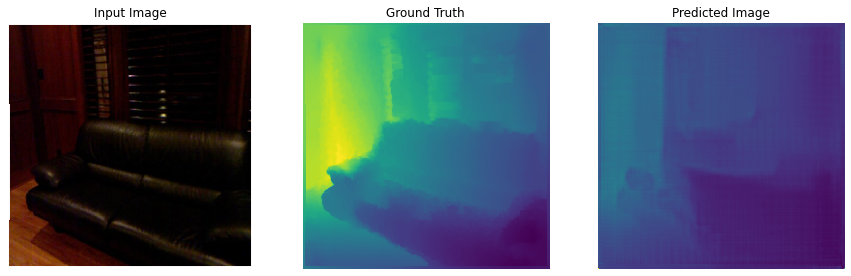

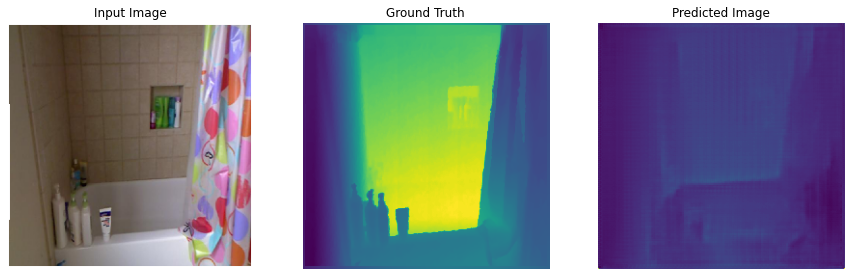

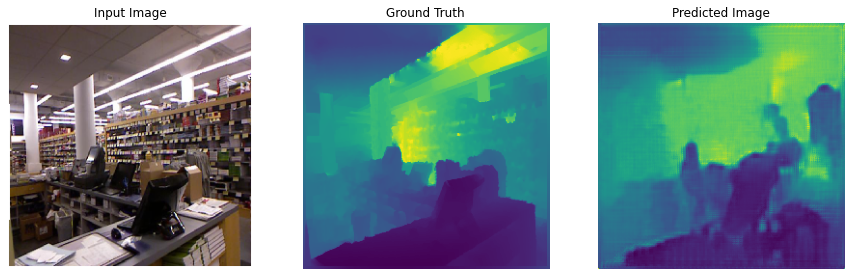

In [59]:
for inp, edge, tar in test_dataset.take(5):
  generate_images(generator, inp, edge, tar)